In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

n = 1000

df = pd.DataFrame({
    'claim_amount': np.random.normal(25000, 10000, n).round(2),
    'injury_type': np.random.choice(['None', 'Minor', 'Major'], n, p=[0.5, 0.3, 0.2]),
    'repair_shop': np.random.choice(['Partnered', 'Non-Partnered'], n),
    'claim_delay': np.random.randint(1, 120, n),
    'vehicle_age': np.random.randint(0, 20, n),
    'num_previous_claims': np.random.randint(0, 5, n),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n),
    'Label': np.random.choice(['Not Fraud', 'Fraud'], n, p=[0.9, 0.1])
})

df.to_csv("insurance_fraud_dataset.csv", index=False)
df.head()

,claim_amount,injury_type,repair_shop,claim_delay,vehicle_age,num_previous_claims,region,Label
0,29967.14,None,Non-Partnered,55,3,0,West,Not Fraud
1,23617.36,None,Non-Partnered,102,9,3,North,Not Fraud
2,31476.89,Minor,Partnered,118,4,3,North,Not Fraud
3,40230.30,Minor,Non-Partnered,82,9,2,South,Not Fraud
4,22658.47,None,Non-Partnered,26,11,2,West,Not Fraud


In [11]:
df = pd.read_csv("insurance_fraud_dataset.csv")

df_encoded = pd.get_dummies(df, columns=['injury_type', 'repair_shop', 'region'], drop_first=True)

df_encoded['Label'] = df_encoded['Label'].map({'Not Fraud': 0, 'Fraud': 1})

X = df_encoded.drop('Label', axis=1)
y = df_encoded['Label']

for col in ['injury_type_Minor', 'repair_shop_Partnered', 'region_North', 'region_South', 'region_West']:
  if col in X.columns:
    X[col] = X[col].astype(int)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1, random_state=42)
y_pred_iso = iso.fit_predict(X)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94       179
           1       0.00      0.00      0.00        21

    accuracy                           0.90       200
   macro avg       0.45      0.50      0.47       200
weighted avg       0.80      0.90      0.85       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
!pip install -q xgboost shap

import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

XGBoost:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       179
           1       0.10      0.05      0.06        21

    accuracy                           0.85       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.81      0.85      0.83       200



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


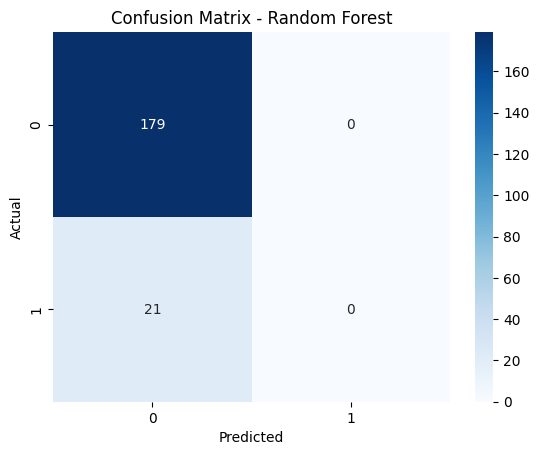

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/tmp/ipython-input-14-768018808.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_fixed, plot_type="bar")


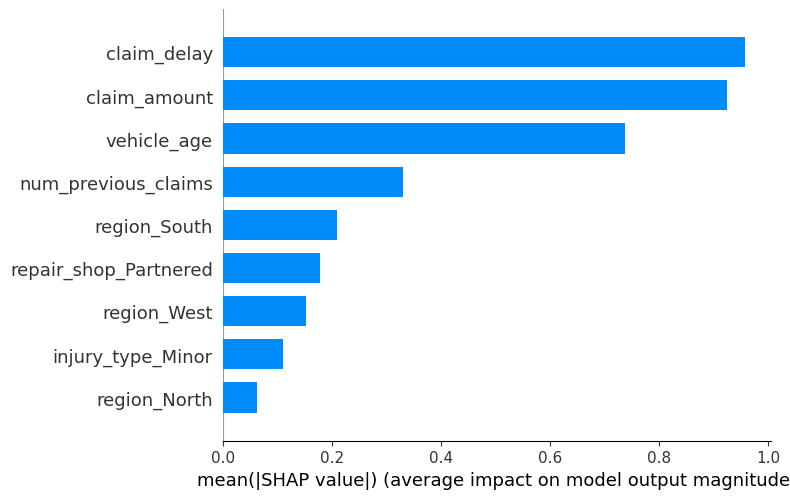

In [14]:
X_test_fixed = pd.DataFrame(X_test, columns=X.columns)
X_test_fixed = X_test_fixed.astype('float64')

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_fixed)

shap.summary_plot(shap_values, X_test_fixed, plot_type="bar")

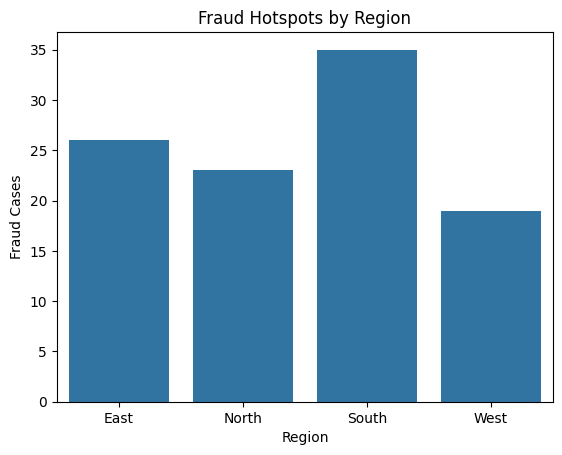

In [16]:
df_plot = df.copy()
df_plot['Label'] = df_plot['Label'].map({'Fraud': 1, 'Not Fraud': 0})
fraud_counts = df_plot.groupby('region')['Label'].sum().reset_index()

sns.barplot(data=fraud_counts, x='region', y='Label')
plt.title("Fraud Hotspots by Region")
plt.xlabel("Region")
plt.ylabel("Fraud Cases")
plt.show()